Successfully loaded feature dataset with shape: (1364, 17)
Data split and scaled. Training set size: 1091, Test set size: 273
--------------------------------------------------
Training LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1091, number of used features: 14
[LightGBM] [Info] Start training from score -1.189715
[LightGBM] [Info] Start training from score -1.151306
[LightGBM] [Info] Start training from score -0.968984
Evaluating model performance...

LightGBM Model Accuracy: 0.6960

Classification Report:
              precision    recall  f1-score   support

    Low Load       0.67      0.76      0.71        83
 Medium Load       0.68      0.53      0.60        86
   High Load       0.73      0.78      0.75       104

    accuracy                           

c:\Users\ayush\OneDrive\Desktop\Intership Project\Intership Project\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


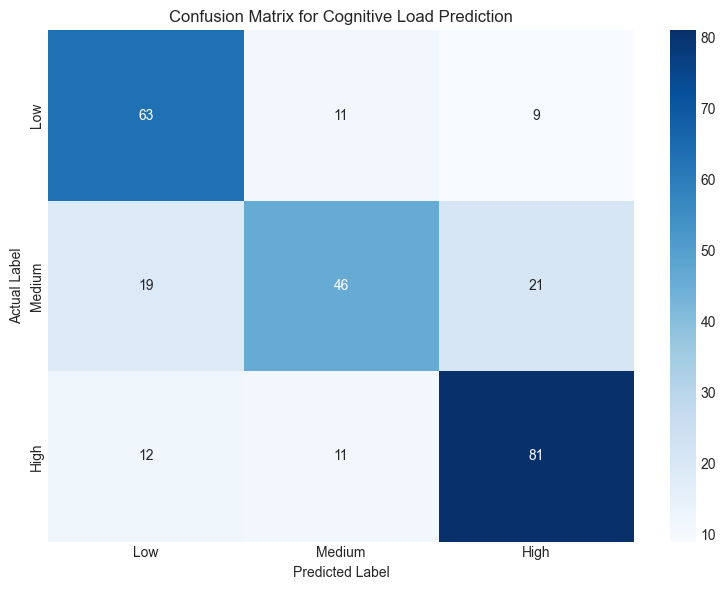

Trained model and scaler saved successfully to: ../models/lgbm_model.pkl


In [1]:
# ## 03 - Modeling with Baseline Classification
#
# *Objective:* Train, evaluate, and save a robust machine learning model using the
# engineered features. We will use LightGBM, a powerful gradient boosting framework,
# which often provides high accuracy on tabular data.
#
# *Input:* ../data/processed/features_dataset.csv
#
# *Output:*
# 1. A classification report printed to the console.
# 2. The trained model saved as lgbm_model.pkl in the ../models/ directory.

import pandas as pd
import lightgbm as lgb
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
PROCESSED_DATA_DIR = '../data/processed/'
MODELS_DIR = '../models/'
INPUT_FILE = os.path.join(PROCESSED_DATA_DIR, 'features_dataset.csv')
MODEL_OUTPUT_FILE = os.path.join(MODELS_DIR, 'lgbm_model.pkl')

# Create the models directory if it doesn't exist
os.makedirs(MODELS_DIR, exist_ok=True)

# --- Load the feature dataset ---
try:
    features_df = pd.read_csv(INPUT_FILE)
    print(f"Successfully loaded feature dataset with shape: {features_df.shape}")
except FileNotFoundError:
    print(f"Error: Input file not found at {INPUT_FILE}")
    print("Please run the '02_feature_engineering.ipynb' notebook first.")
    exit()

# --- Prepare Data for Modeling ---
# Define features (X) and target (y)
X = features_df.drop(columns=['Participant', 'TaskKey', 'CognitiveLoad'])
y = features_df['CognitiveLoad']

# Split data into 80% for training and 20% for testing, ensuring class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Feature Scaling ---
# Scale features to have zero mean and unit variance for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Data split and scaled. Training set size: {X_train_scaled.shape[0]}, Test set size: {X_test_scaled.shape[0]}")
print("-" * 50)

# --- Train the LightGBM Model ---
print("Training LightGBM model...")
lgbm = lgb.LGBMClassifier(random_state=42)
lgbm.fit(X_train_scaled, y_train)

# --- Evaluate the Model ---
print("Evaluating model performance...")
y_pred = lgbm.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Low Load', 'Medium Load', 'High Load'])

print(f"\nLightGBM Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("-" * 50)

# --- Visualize the Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix for Cognitive Load Prediction')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


# --- Save the Trained Model and Scaler ---
# We save both the model and the scaler. The scaler is needed to process
# any new data before making predictions.
model_payload = {
    'model': lgbm,
    'scaler': scaler
}
joblib.dump(model_payload, MODEL_OUTPUT_FILE)
print(f"Trained model and scaler saved successfully to: {MODEL_OUTPUT_FILE}")